## **PRODUCT CATEGORY CLASSIFICATION**

### Here, we want to develop an automatic and scalable first prototipe that helps to correctly categorize a new product in the available categories when it arrives.

This first prototipe will help us to identify in what elements we have to go deeper in order to get the best model.


https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
https://www.dataquest.io/blog/natural-language-processing-with-python/

## **Summary of requirements**

1. Train a model that predicts the product category for Software, Digital Software, and
Digital Video Games products using the Amazon Customer Reviews dataset.
2. Evaluate and validate your model.

In [1]:
# I checked warnings, but for the final report I prefer ignore those 
#that really does not affect the results (warnings of libraries, etc)
import warnings
warnings.simplefilter('ignore')

In [2]:
import platform
platform.architecture()[0]

'64bit'

In [3]:
#Further improvement: develop an enviroment
# Basic Modules
import os
import pandas as pd
import numpy as np
import boto3
import json
import matplotlib.pyplot as plt
#from sagemaker.predictor import json_deserializer

In [4]:
#MOdels
from sklearn.linear_model import LogisticRegression

In [5]:
# Modules for tokens
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
#my own functions
%load_ext autoreload
%autoreload 2

from utils.py_functions import *
from utils.cleaning_functions import *

## **DATA**
For our problem we use will three datasets from public datasets of Amazon. This datasets contains Customer Reviews fro three category of products.

* Software
* Digital Software
* Digital video games

In [7]:
'''
!mkdir /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz /tmp/recsys/
!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz /tmp/recsys/
'''

'\n!mkdir /tmp/recsys/\n!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz /tmp/recsys/\n!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz /tmp/recsys/\n!aws s3 cp s3://amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz /tmp/recsys/\n'

In [8]:
df_video_games = pd.read_csv('data/amazon_reviews_us_Digital_Video_Games_v1_00.tsv', delimiter = '\t', error_bad_lines = False)
print('Number of rows: ', df_video_games.shape)
df_software = pd.read_csv('data/amazon_reviews_us_Software_v1_00.tsv', delimiter = '\t', error_bad_lines = False)
print('Number of rows: ', df_software.shape)
df_digital_software = pd.read_csv('data/amazon_reviews_us_Digital_Software_v1_00.tsv', delimiter = '\t', error_bad_lines = False)
print('Number of rows: ', df_digital_software.shape)

Number of rows:  (144724, 15)


b'Skipping line 8021: expected 15 fields, saw 22\nSkipping line 34886: expected 15 fields, saw 22\nSkipping line 49286: expected 15 fields, saw 22\n'


Number of rows:  (341249, 15)
Number of rows:  (101836, 15)


In [9]:
df_video_games.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

## **Dataset columns**

* marketplace: 2-letter country
* customer_id: random identifier for a customer
* review_id: unique id for the review
* product_id: ASIN number. Unique id for product
* product_parent: the parent of that ASIN. Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
* product_title: title/description of the product
* product_category: brad product category
* star_rating: 1 to 5 stars (review rating)
* helpful_votes: Number of helpful votes for the review
* total_votes: number of total votes the review received
* vine: Was the review written as part of the VIne program?
* verified_purchase: Was the review from a verified purchase?
* review_headline: the title of the review itself
* review_body: text of the review
* review_date: the date of the review was written.

In [10]:
df_video_games.tail()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
144719,US,53011810,R2G7DI8NYXZB5R,B001AUEITS,163061733,Crazy Machines 2 [Download],Digital_Video_Games,4,2,3,N,N,Worked first try for me,"I was worried due to the 2 reviews I saw here,...",2008-12-25
144720,US,53094564,R3QRKP4DS759BP,B001AU6TQ8,801870836,Crazy Machines 1 - The Wacky Contraptions Game...,Digital_Video_Games,1,13,16,N,N,"The Software May be Great, But I'll Never Know",I downloaded this as a Christmas present for m...,2008-12-24
144721,US,37181147,R24K4C0ZC3093U,B001AUEITS,163061733,Crazy Machines 2 [Download],Digital_Video_Games,3,3,3,N,N,Some install problems but good otherwise,The previous reviewer is correct in noting tha...,2008-09-10
144722,US,18614365,R13OA3TRCM8IBM,B001AUEITS,163061733,Crazy Machines 2 [Download],Digital_Video_Games,1,20,22,N,N,Do Not Download This!,I downloaded this for my son's birthday yester...,2008-09-01
144723,US,28326760,R1PFDIHC9TM6V4,B000AQ7K4I,99419628,Emperor of the Fading Suns,Digital_Video_Games,4,4,4,N,N,Suprisingly large scale and complex strategy game,This game has all the makings of a wonderful t...,2006-08-08


## **DROP SOME COLUMNS**

### When a new product arrives the only available information would be product title. A new product will not have rating, votes or reviews.

In [11]:
df_digital_software = df_digital_software.drop(columns = ['marketplace', 'customer_id', 'product_parent', 'vine', 'review_date'])
df_software         = df_software.drop(columns = ['marketplace', 'customer_id', 'product_parent',  'vine', 'review_date'])
df_video_games      = df_video_games.drop(columns = ['marketplace', 'customer_id', 'product_parent', 'vine', 'review_date'])

In [12]:
df = pd.concat([df_digital_software, df_video_games, df_software], axis=0)
df.tail()

,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
341244,R22N983F9Y5B7H,0877794618,Merriam-Webster’s Medical Audio Dictionary,Software,5,5,7,N,"My name is Maeda, and I love this CR-ROM.",I am a medical student. I loved this CD-ROM v...
341245,RZ9DND08T95KF,0877794618,Merriam-Webster’s Medical Audio Dictionary,Software,5,3,5,N,I'd rather give 6 stars to this title,"I tried a Taber's, but was disappointed: he do..."
341246,R3EDTMHC38P95O,B00002SV6E,Star Wars: Droid Works,Software,4,1,1,N,Droid building,You get to build droids even ones in existence...
341247,R1LYRNM6CTLUG4,0671573535,Star Trek Borg,Software,1,0,2,N,don't buy this game,We have not been able to even run this game be...
341248,R21PP8R25RNBKG,0877794618,Merriam-Webster’s Medical Audio Dictionary,Software,3,12,13,N,An Easy-to-Use Medical Dictionary with Excelle...,Merriam-Webster's Medical Audio Dictionary is ...


In [13]:
df.dtypes

review_id            object
product_id           object
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
verified_purchase    object
review_headline      object
review_body          object
dtype: object

## **CHECK IF WE HAVE MISSING VALUES**

We have missing data in review_headline, review_body. We have to eliminate it or fix this in order to keep going with the analysis. 

In [14]:
## check for missing values
df.isnull().sum()

review_id            0
product_id           0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
verified_purchase    0
review_headline      5
review_body          4
dtype: int64

### We can see that the na's are not at the same rows.

In [15]:

df[df.isnull().any(axis=1)]

,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
3074,R3355NIW709DC7,B00452VGXO,The Sims 3 Late Night,Digital_Video_Games,1,0,0,Y,NaN,Product code does not work.
11907,RKHI9WDB7S5WR,B008D7F47Q,FIFA Soccer 13,Digital_Video_Games,5,0,0,N,Five Stars,NaN
14470,R2UJ6J6TUON90A,B00S00IJH8,Sims 4,Digital_Video_Games,2,0,2,N,Two Stars,NaN
128119,RNKTSBVIU8VUI,B004VSTQ2A,Xbox Live Subscription,Digital_Video_Games,1,1,8,Y,NaN,I DID NOT BUY THIS PRODUCT SO I AM CONFUSED AS...
21683,R3PR9MGYHNCQY8,B00MUTB2SS,McAfee 2015 Antivirus Plus 3 PC (3-Users),Software,1,1,1,Y,NaN,I am giving this one star because I am unable ...
55474,RBTYQ8AT2FYQO,B00EOI2ND6,HRB 2011 Basic FFP Test ASIN (Formerly: Micros...,Software,4,0,0,N,Four Stars,NaN
76722,R2BMEAJE97HVS1,B001GL6QHS,TurboTax Deluxe Federal + State + eFile 2008,Software,4,0,0,Y,Four Stars,NaN
178530,R11DUZE2KLAAWW,B000M9DOTS,MorphVOX Pro - Voice Changer,Software,4,0,1,Y,NaN,Product worked was able to play with applicati...
281897,R19OZEXLR6BHQB,B00008NNY0,Instant CD/DVD,Software,1,0,4,N,NaN,Shortly after buying the product I had to repl...


### Fill values

In [16]:
df.review_headline.fillna(df.review_body, inplace=True)
df.review_body.fillna(df.review_headline, inplace=True)

## **Check for white strings**

In [17]:
blanks = []  # start with an empty list

for i,lb,rv in df[['product_category','review_body']].itertuples():  # iterate over the DataFrame , 'product_title', 'verified_purchase', 'review_headline'
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [18]:
blanks = []  # start with an empty list

for i,lb,rv in df[['product_title', 'review_headline']].itertuples():  # iterate over the DataFrame , 
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks), 'blanks: ', blanks)  

0 blanks:  []


## **Check duplicates**

We can se that we have several duplicated values.

In [19]:
df[df.drop(columns = ['review_id']).duplicated()]

,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
384,RMEZL8TXWV4M,B00LH6ZWIG,Autodesk Sketchbook Pro 7,Digital_Software,4,0,0,N,Great on the Surface Pro 3,I use this as a drawing program on the desktop...
1608,R323M3Q9QPSKWC,B0064PFB9U,Office Mac Home and Student 2011 - 1PC/1User [...,Digital_Software,5,0,0,Y,Five Stars,perfect
1659,R2BT71OH5WHUC0,B00PT6GQY4,LibreOffice v4.3,Digital_Software,4,0,0,N,IT IS OKAY,WELL IT IS NOT MICROSOFT OFFICE 365. BUT IT WO...
1954,RTSQYFWGYN3A,B00PT6GQY4,LibreOffice v4.3,Digital_Software,4,0,0,N,Works fine,It seems to work okay and does resemble Micros...
2923,R35L0R8D2TH7HZ,B00B1TGUMG,Microsoft Office Home and Student 2013 (1PC/1U...,Digital_Software,5,0,0,Y,Five Stars,Great!
...,...,...,...,...,...,...,...,...,...,...
338808,R3BIKLE2AZMTPA,B00002SAGF,Ez-gig Data Transfer Software License (50-pack),Software,4,0,1,N,Wowsers! Holy Gigabytes Amazon!!,This has to be one of the most useful tools ou...
338812,REMWOWSZNS6CX,B00002SAGF,Ez-gig Data Transfer Software License (50-pack),Software,4,0,1,N,Wowsers! Holy Gigabytes Amazon!!,This has to be one of the most useful tools ou...
339247,R1MKLNG8NI2TLI,B00004TFIV,Strata 3D 3.0,Software,4,0,0,N,Cool and Easy,This is very easy to use and it has lots of go...
339249,R39RCD5P43QKOR,B00004TFIV,Strata 3D 3.0,Software,4,0,0,N,Cool and Easy,This is very easy to use and it has lots of go...


In [20]:
df[df['review_headline'] == 'Great on the Surface Pro 3']

,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
268,RCN514M5V71WZ,B00LH6ZWIG,Autodesk Sketchbook Pro 7,Digital_Software,4,0,0,N,Great on the Surface Pro 3,I use this as a drawing program on the desktop...
384,RMEZL8TXWV4M,B00LH6ZWIG,Autodesk Sketchbook Pro 7,Digital_Software,4,0,0,N,Great on the Surface Pro 3,I use this as a drawing program on the desktop...
20083,R2XKOPOLVZAHP8,B00LH6ZWIG,Autodesk Sketchbook Pro 7,Digital_Software,4,0,0,Y,Great on the Surface Pro 3,I use this as a drawing program on the desktop...


In [21]:
#So, we eliminate them
print(df.shape)
df = df.drop_duplicates(subset = ['product_id', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes',  'verified_purchase', 
                                     'review_headline', 'review_body'], keep = 'first')
print(df.shape)

(587809, 10)
(584642, 10)


In [22]:
df.head()

,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body
0,R2EI7QLPK4LF7U,B00U7LCE6A,CCleaner Free [Download],Digital_Software,4,0,0,Y,Four Stars,So far so good
1,R1W5OMFK1Q3I3O,B00HRJMOM4,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,Y,Three Stars,Needs a little more work.....
2,RPZWSYWRP92GI,B00P31G9PQ,Amazon Drive Desktop [PC],Digital_Software,1,1,2,Y,One Star,Please cancel.
3,R2WQWM04XHD9US,B00FGDEPDY,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,Y,Works as Expected!,Works as Expected!
4,R1WSPK2RA2PDEF,B00FZ0FK0U,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...


In [23]:
df = df.drop_duplicates(subset = ['product_id', 'product_title', 'product_category', 'review_headline', 'review_body'], keep = 'first')

In [24]:
df.shape

(583986, 10)

# **IS BALANCED?**

In [25]:
100*df.groupby("product_category")['product_id'].count()/df.shape[0]

product_category
Digital_Software       17.373362
Digital_Video_Games    24.294418
Software               58.332220
Name: product_id, dtype: float64

In [26]:
dicti = {"Digital_Software": 0, "Digital_Video_Games": 1, "Software": 2}
df['product_category_label'] = df['product_category']
df = df.replace({"product_category": dicti})

## **FILTER VALUES**

In [27]:
df = df.sort_values(by=['product_id', 'helpful_votes'], ascending=True)
#df = df.drop_duplicates(subset = ['product_title'], keep = 'first') # only products
df.head()

,review_id,product_id,product_title,product_category,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,product_category_label
314231,RING4VEIUW4Y1,0028650506,BLACK MUSIC OF TWO WORLDS CD,2,1,0,0,N,teachers and students BEWARE !!!,I have enjoyed and admired John Storm Robert's...,Software
318101,R38LNO9CFVPKQS,0030331927,INTERMEDIATE FIN MGMT 7E,2,5,3,15,N,one of the best sources of corporate finance,one of the best sources of corporate finance,Software
66009,RABIWWF1PLRZ4,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",2,3,0,0,Y,Loses One's Attention,I expected better quality. The video is fuzzy ...,Software
109034,R131XDRSFWXBGA,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",2,5,0,0,Y,This is one of my favorite kids spanish learni...,This is great immersion type learning for the ...,Software
203472,RB2EAMTUSLP1V,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",2,5,2,2,Y,Grown ups even like it!,"My husband and I are in our 50's, are beginnin...",Software


## **PRODUCT TITLE**

### **INCLUDE NUMERICAL INFO ABOUT THE NAME OF THE PRODUCT**

In [28]:
# include other features
import re
# Our list of functions to apply.
transform_functions = [
    lambda x: len(x),
    lambda x: x.count(" "),
    lambda x: x.count("."),
    lambda x: x.count("!"),
    lambda x: x.count("?"),
    lambda x: len(x) / (x.count(" ") + 1),
    lambda x: x.count(" ") / (x.count(".") + 1),
    lambda x: len(re.findall("CD|DVD", x)), # CD 
    lambda x: len(re.findall(r"\d+st|\d+th|\d+sd", x)), # th--> 4th, 5th or 1st or 2sd
    lambda x: len(re.findall("[A-Z]", x)), # number of uppercase letters
    lambda x: len(re.findall("[0-9]", x)), #numbers
    lambda x: len(re.findall("\d{4}", x)),
    lambda x: len(re.findall("\d$", x)), #end with number
    lambda x: len(re.findall("^\d", x)), #start with number
    lambda x: len(re.findall("[\w]+-[\w]+",x)), #words separated with -
    lambda x: len(re.findall("OLD VERSION|Old Version|old version",x)), #old version
]

transform_functions_len = [
    lambda x: len(x)
]

# Apply each function and put the results into a list.
df_num = df[['review_id', 'product_id', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase']]
df_num_2 = df[['review_id', 'product_id', 'product_title']]
df = df.drop(columns = ['star_rating', 'helpful_votes', 'total_votes', 'verified_purchase'])


In [29]:
for func in transform_functions:
     df_num_2 = pd.concat([df_num_2, df['product_title'].apply(func)], axis=1)
df_num_2 = pd.concat([df_num_2, df['review_body'].apply(transform_functions_len)], axis=1)
df_num_2 = pd.concat([df_num_2, df['review_headline'].apply(transform_functions_len)], axis=1)

In [30]:
df_num_2.head()

,review_id,product_id,product_title,product_title,product_title,product_title,product_title,product_title,product_title,product_title,...,product_title,product_title,product_title,product_title,product_title,product_title,product_title,product_title,<lambda>,<lambda>
314231,RING4VEIUW4Y1,0028650506,BLACK MUSIC OF TWO WORLDS CD,28,5,0,0,0,4.666667,5.0,...,0,23,0,0,0,0,0,0,1066,32
318101,R38LNO9CFVPKQS,0030331927,INTERMEDIATE FIN MGMT 7E,24,3,0,0,0,6.000000,3.0,...,0,20,1,0,0,0,0,0,44,44
66009,RABIWWF1PLRZ4,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",102,17,0,0,0,5.666667,17.0,...,0,15,2,0,0,0,0,0,275,21
109034,R131XDRSFWXBGA,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",102,17,0,0,0,5.666667,17.0,...,0,15,2,0,0,0,0,0,232,55
203472,RB2EAMTUSLP1V,0071480935,"Sing, Watch, &amp; Learn Spanish (DVD + Guide)...",102,17,0,0,0,5.666667,17.0,...,0,15,2,0,0,0,0,0,415,23


In [31]:
df_num_2.columns = ['review_id', 'product_id', 'product_title', 'title_len', 'title_words', 'title_points',
                  'title_exc', 'title_int', 'ratio_spaces_point', 
                  'ratio_len_points', 'title_cd','title_th', 'title_upper_letters', 'title_numbers', 'title_years', 'end_number', 'starts_number', 'word_sep', 
                  'title_old_version', 'len_review_body', 'len_review_headline']

## **Combine tables**

In [32]:
from functools import reduce
dfs = [df, df_num, df_num_2]
df = reduce(lambda left,right: pd.merge(left,right,on=['review_id', 'product_id', 'product_title'], how = 'inner'), dfs)

# **Some descriptive values**

* How do ratings vary by product category?

It appears that Digital Software is the most disappointing category for reviewers, 


In [33]:
df.groupby(['product_category'])['star_rating'].mean()

product_category
0    3.534832
1    3.830035
2    3.565401
Name: star_rating, dtype: float64

In [34]:
df.groupby(['product_category'])['helpful_votes'].sum()

product_category
0     249703
1     215137
2    1489793
Name: helpful_votes, dtype: int64

In [35]:
df.columns

Index(['review_id', 'product_id', 'product_title', 'product_category',
       'review_headline', 'review_body', 'product_category_label',
       'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase',
       'title_len', 'title_words', 'title_points', 'title_exc', 'title_int',
       'ratio_spaces_point', 'ratio_len_points', 'title_cd', 'title_th',
       'title_upper_letters', 'title_numbers', 'title_years', 'end_number',
       'starts_number', 'word_sep', 'title_old_version', 'len_review_body',
       'len_review_headline'],
      dtype='object')

In [36]:
df.groupby(['product_category'])['helpful_votes'].sum()

product_category
0     249703
1     215137
2    1489793
Name: helpful_votes, dtype: int64

As you can observe, more than 75% of reviews have not been found helpful by people, and among those who were found helpful, the review text has an average length of more than 150 words. While most of the reviews were given 4 or 5 stars, there is no clear pattern between the rating and the length of the reviews. 

So, longer reviews are more helpful, but it does not mean people liked the product more? Well, we need a better way to untangle this mess.

In [37]:
df.groupby(['star_rating'])['title_len'].mean().reset_index().head()

,star_rating,title_len
0,1,37.490442
1,2,37.563492
2,3,37.700297
3,4,38.275103
4,5,38.572880


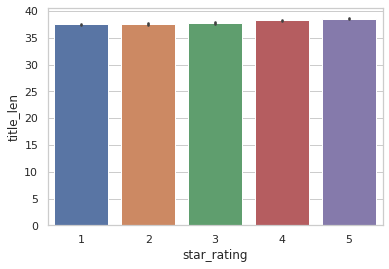

In [38]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="star_rating", y="title_len", data=df)

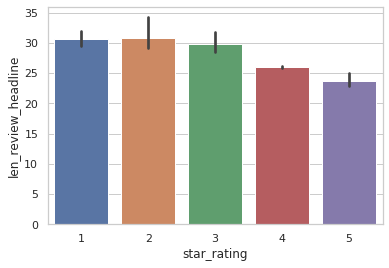

In [39]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="star_rating", y="len_review_headline", data=df)

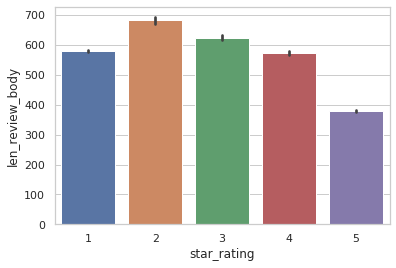

In [40]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="star_rating", y="len_review_body", data=df)

In [41]:
df.groupby(['star_rating'])['helpful_votes'].mean().reset_index().head()

,star_rating,helpful_votes
0,1,6.113543
1,2,4.645945
2,3,3.466172
3,4,2.700161
4,5,2.140457


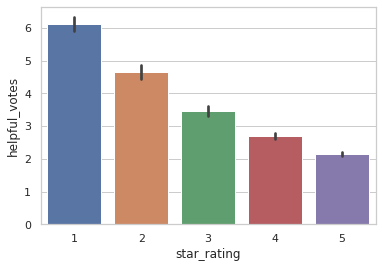

In [42]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.barplot(x="star_rating", y="helpful_votes", data=df)

## **Text data processing**

We cleaned the review text to remove all ‘noise’ (in this case, that translates to punctuation, junk values and upper case letters). 

In [43]:
#clean characters
df = standardize_text(df, "product_title")

## **Eliminate stop words**

In [44]:
#download stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/erikapat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/erikapat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['product_title'] = df['product_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#df['review_headline'] = df['review_headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#df['review_body'] = df['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#more cleaning
df['product_title'] = df['product_title'].map(lambda x : clean_text(x))
#df['review_headline'] = df['review_headline'].map(lambda x : clean_text(x))
#df['review_body'] = df['review_body'].map(lambda x : clean_text(x))
df['product_title'] = df['product_title'].map(lambda x : removeAscendingChar(x)) 
#df['review_headline'] = df['review_headline'].map(lambda x : removeAscendingChar(x)) 
#df['review_body'] = df['review_body'].map(lambda x : removeAscendingChar(x)) 

## **Lemmatization**

Reduce the inflectional forms of each word into a common base or root. For example, it’s very likely we will want to see results containing the form “skirt” if we have typed “skirts” in a search bar.

![alt text](fig/lemma.png)

In [46]:
#lemmatization
df['product_title'] = df['product_title'].map(lambda x : lemitizeWords(x))
df['review_headline'] = df['review_headline'].map(lambda x : lemitizeWords(x))
df['review_body'] = df['review_body'].map(lambda x : lemitizeWords(x))

In [47]:
#eliminate single letters
df['product_title'] = df['product_title'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['review_headline'] = df['review_headline'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
df['review_body'] = df['review_body'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')

## **Spelling correction**

In [48]:
from textblob import TextBlob
#df['product_title'] = df['product_title'].apply(lambda tweet: TextBlob(tweet).correct())
#df['review_headline'] = df['review_headline'].apply(lambda tweet: TextBlob(tweet).correct())
#df['review_body'] = df['review_body'].apply(lambda tweet: TextBlob(tweet).correct())

In [49]:
df.head()

,review_id,product_id,product_title,product_category,review_headline,review_body,product_category_label,star_rating,helpful_votes,total_votes,...,title_th,title_upper_letters,title_numbers,title_years,end_number,starts_number,word_sep,title_old_version,len_review_body,len_review_headline
0,RING4VEIUW4Y1,0028650506,black music worlds cd,2,teachers and students BEWARE !!!,have enjoyed and admired John Storm Robert' b...,Software,1,0,0,...,0,23,0,0,0,0,0,0,1066,32
1,R38LNO9CFVPKQS,0030331927,intermediate fin mgmt,2,one of the best sources of corporate finance,one of the best sources of corporate finance,Software,5,3,15,...,0,20,1,0,0,0,0,0,44,44
2,RABIWWF1PLRZ4,0071480935,sing watc amp learn spanis fun music videos in...,2,Loses One' Attention,expected better quality. The video is fuzzy a...,Software,3,0,0,...,0,15,2,0,0,0,0,0,275,21
3,R131XDRSFWXBGA,0071480935,sing watc amp learn spanis fun music videos in...,2,This is one of my favorite kids spanish learni...,This is great immersion type learning for the ...,Software,5,0,0,...,0,15,2,0,0,0,0,0,232,55
4,RB2EAMTUSLP1V,0071480935,sing watc amp learn spanis fun music videos in...,2,Grown ups even like it!,"My husband and are in our 50', are beginning S...",Software,5,2,2,...,0,15,2,0,0,0,0,0,415,23


## **The objective/subjective part of the sentence: Textblob package**


* To install:

pip install -U textblob

python -m textblob.download_corpora

With the Textblob package we can eliminate the objective/subjective part of a setence. Why do this? Think about it. Would you rather read ‘This iPhone has 64 gb of storage’ or ‘This iPhone has high storage for low price’? Depending of the utility of the project you would need the objective or Subjectivity part. Textblob does a good job of telling you how subjective a sentence is, using which you can eliminate those that fall below a certain threshold 

In our case we want to eliminate subjectivity an keep those sentences that give us more objective information about the product. We picked a threshold below 0.3. 

More info in: https://textblob.readthedocs.io/en/dev/

In [50]:
from textblob import TextBlob
#df['review_body'].apply(lambda tweet: TextBlob(tweet).sentiment) # (polarity, subjectivity) 
#xx = df['review_body'].apply(lambda tweet: TextBlob(tweet).noun_phrases) 

In [51]:
df['review_body'].head()

0     have enjoyed and admired John Storm Robert' b...
1         one of the best sources of corporate finance
2     expected better quality. The video is fuzzy a...
3    This is great immersion type learning for the ...
4    My husband and are in our 50', are beginning S...
Name: review_body, dtype: object

## **BASELINE MODEL** 

First we will develop a simple model, that we are going to use as Baseline.

For our baseline model we will do:
* Tokenizing sentences to a list of separate words
* Creating a train test split
* Inspecting our data a little more to validate results

In [52]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["token_product_title"] = df["product_title"].apply(tokenizer.tokenize)
df["token_review_body"] = df["review_body"].apply(tokenizer.tokenize)
df["token_review_headline"] = df["review_headline"].apply(tokenizer.tokenize)

## **Inspecting tokens**

In [53]:
sentence_lengths_1 = descriptive_tokens(df, name = "token_product_title")
sentence_lengths_2 = descriptive_tokens(df, name = "token_review_body")
sentence_lengths_3 = descriptive_tokens(df, name = "token_review_headline")

Column  token_product_title  have 2643429 words total, with a vocabulary size of 16260
Max sentence length is 52
Column  token_review_body  have 49261970 words total, with a vocabulary size of 233708
Max sentence length is 7902
Column  token_review_headline  have 2639758 words total, with a vocabulary size of 65131
Max sentence length is 24706


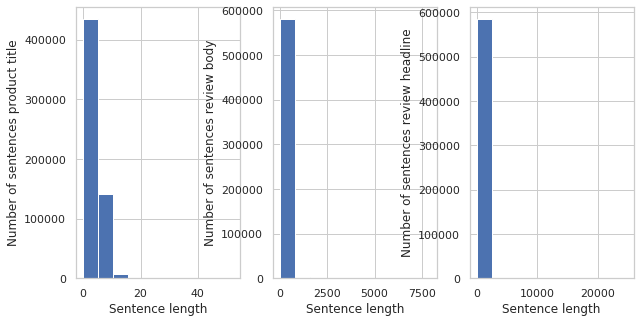

In [54]:
%matplotlib inline
fig= plt.figure(figsize=(10, 5)) 
plt.subplot(1, 3, 1) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences product title')
plt.hist(sentence_lengths_1)
plt.subplot(1, 3, 2)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences review body')
plt.hist(sentence_lengths_2)
plt.subplot(1, 3, 3)
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences review headline')
plt.hist(sentence_lengths_3)
plt.show()

In [55]:
## **concatenate columns**

#We will use a concatination of columns, to see if we include review information or not

#
#df['full_text'] = df["product_title"] + " " + df["review_body"]  + " " + df["review_headline"]
df['product_title'] = df["product_title"] #+ " " + df["review_body"] #  + " " + df["review_headline"] #

In [56]:
df.head()

,review_id,product_id,product_title,product_category,review_headline,review_body,product_category_label,star_rating,helpful_votes,total_votes,...,title_years,end_number,starts_number,word_sep,title_old_version,len_review_body,len_review_headline,token_product_title,token_review_body,token_review_headline
0,RING4VEIUW4Y1,0028650506,black music worlds cd,2,teachers and students BEWARE !!!,have enjoyed and admired John Storm Robert' b...,Software,1,0,0,...,0,0,0,0,0,1066,32,"[black, music, worlds, cd]","[have, enjoyed, and, admired, John, Storm, Rob...","[teachers, and, students, BEWARE]"
1,R38LNO9CFVPKQS,0030331927,intermediate fin mgmt,2,one of the best sources of corporate finance,one of the best sources of corporate finance,Software,5,3,15,...,0,0,0,0,0,44,44,"[intermediate, fin, mgmt]","[one, of, the, best, sources, of, corporate, f...","[one, of, the, best, sources, of, corporate, f..."
2,RABIWWF1PLRZ4,0071480935,sing watc amp learn spanis fun music videos in...,2,Loses One' Attention,expected better quality. The video is fuzzy a...,Software,3,0,0,...,0,0,0,0,0,275,21,"[sing, watc, amp, learn, spanis, fun, music, v...","[expected, better, quality, The, video, is, fu...","[Loses, One, Attention]"
3,R131XDRSFWXBGA,0071480935,sing watc amp learn spanis fun music videos in...,2,This is one of my favorite kids spanish learni...,This is great immersion type learning for the ...,Software,5,0,0,...,0,0,0,0,0,232,55,"[sing, watc, amp, learn, spanis, fun, music, v...","[This, is, great, immersion, type, learning, f...","[This, is, one, of, my, favorite, kids, spanis..."
4,RB2EAMTUSLP1V,0071480935,sing watc amp learn spanis fun music videos in...,2,Grown ups even like it!,"My husband and are in our 50', are beginning S...",Software,5,2,2,...,0,0,0,0,0,415,23,"[sing, watc, amp, learn, spanis, fun, music, v...","[My, husband, and, are, in, our, 50, are, begi...","[Grown, ups, even, like, it]"


## **Enter embeddings**

Machine Learning on images can use raw pixels as inputs. A way to represent text is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence in our dataset, and then use these embeddings to accurately predict the relevant category.

The most simplest approach is to use a **bag of words model**, and apply a machine learning algorimth (like, logistic, naive bayes, between others). A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.

## **Bag of Words**

### **combine numerica and nonnumeric data**

In [57]:
df.columns

Index(['review_id', 'product_id', 'product_title', 'product_category',
       'review_headline', 'review_body', 'product_category_label',
       'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase',
       'title_len', 'title_words', 'title_points', 'title_exc', 'title_int',
       'ratio_spaces_point', 'ratio_len_points', 'title_cd', 'title_th',
       'title_upper_letters', 'title_numbers', 'title_years', 'end_number',
       'starts_number', 'word_sep', 'title_old_version', 'len_review_body',
       'len_review_headline', 'token_product_title', 'token_review_body',
       'token_review_headline'],
      dtype='object')

In [58]:
from sklearn.model_selection import train_test_split
df['product_title'] = df['review_headline']
cols = ['product_title', 'title_len', 'title_words', 'title_points', 'title_exc', 'title_int',
       'ratio_spaces_point', 'ratio_len_points', 'title_cd', 'title_th',
       'title_upper_letters', 'title_numbers', 'title_years', 'end_number',
       'starts_number', 'word_sep', 'title_old_version', 'len_review_body',
       'len_review_headline', 'token_product_title', 'token_review_body',
       'token_review_headline']

df_corpus = df[cols]
df_labels = df["product_category"] 

X_train, X_test, y_train, y_test = train_test_split(df_corpus, df_labels, test_size=0.2, 
                                                                                random_state=40)


In [59]:
X_train.head()

,product_title,title_len,title_words,title_points,title_exc,title_int,ratio_spaces_point,ratio_len_points,title_cd,title_th,...,title_years,end_number,starts_number,word_sep,title_old_version,len_review_body,len_review_headline,token_product_title,token_review_body,token_review_headline
377421,great,45,7,0,0,0,5.625000,7.0,0,0,...,1,1,0,1,0,126,5,"[turbotax, deluxe, federal, efile, state]","[normally, just, go, to, the, local, office, s...",[great]
460384,Five Stars,19,3,0,0,0,4.750000,3.0,0,0,...,0,0,0,0,0,18,10,"[xbox, live, gift, card]","[Quick, and, accurate]","[Five, Stars]"
548103,Great tax software.,45,8,0,0,0,5.000000,8.0,0,0,...,0,0,0,1,0,197,19,"[turbotax, ome, business, fed, efile, state]","[It, turbotax, and, have, been, using, it, sin...","[Great, tax, software]"
82371,review,52,7,0,0,0,6.500000,7.0,0,0,...,1,0,0,0,1,125,6,"[microsoft, office, ome, student, old, version]","[product, was, useful, for, what, needed, Arri...",[review]
473492,Four Stars,28,5,0,0,0,4.666667,5.0,0,0,...,0,0,0,0,0,69,10,"[norton, user, licenses]","[Works, as, advertised, not, much, slowing, wh...","[Four, Stars]"


In [60]:
y_test.value_counts()

2    68041
1    28312
0    20445
Name: product_category, dtype: int64

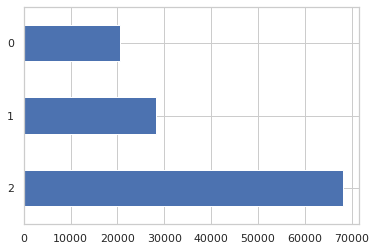

In [61]:
y_test.value_counts().plot('barh') 

In [62]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

X_train_counts, count_vectorizer = cv(X_train['product_title'])
X_test_counts = count_vectorizer.transform(X_test['product_title'])

In [63]:
print(X_train_counts.shape)

(467188, 39954)


In [64]:
#print(X_train_counts.todense())

## **CHI-SQUARED**

We’ve constructed a matrix, that have a lot of unique words/columns. This data configuratio will take a very long time to make predictions. We want to speed it up, so we’ll need to cut down the column count somehow. One way to do this is to pick a subset of the columns that are the most informative.

In [65]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# Find the 1000 most informative columns
selector = SelectKBest(chi2, k=1000) #further work:check other alternatives
selector.fit(X_train_counts, y_train)
top_words = selector.get_support().nonzero()

# Pick only the most informative columns in the data.
chi_matrix = X_train_counts[:,top_words[0]]

In [66]:
print(chi_matrix.shape)

(467188, 1000)


In [67]:
X_train_counts = chi_matrix.copy()

In [68]:
print(X_train_counts.shape)

(467188, 1000)


In [69]:
#TOP WORDS FOR TEST
X_test_counts = X_test_counts[:,top_words[0]]

In [70]:
print(X_test_counts.shape)

(116798, 1000)


## **NUMERICAL VARIABLES**

In [71]:
cols = ['title_len', 'title_words', 'title_points', 'title_exc', 'title_int',
       'ratio_spaces_point', 'ratio_len_points', 'title_cd', 'title_th',
       'title_upper_letters', 'title_numbers', 'title_years', 'end_number',
       'starts_number', 'word_sep', 'title_old_version', 'len_review_body',
       'len_review_headline']

In [72]:
X_train_num = X_train[cols]
X_test_num = X_test[cols]

In [73]:
#len(X_train_counts.todense())

In [74]:
len(X_train_num)

467188

In [75]:
#X_train_counts = np.hstack([X_train_counts.todense(),np.asarray(X_train_num)])

In [76]:
#X_test_counts = np.hstack([X_test_counts.todense(), np.asarray(X_test_num)])

In [77]:
X_test_counts

<116798x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 320738 stored elements in Compressed Sparse Row format>

## **Visualizing the embeddings**

Here, we apply linear dimensionality reduction to see if we can find separations between the groups.

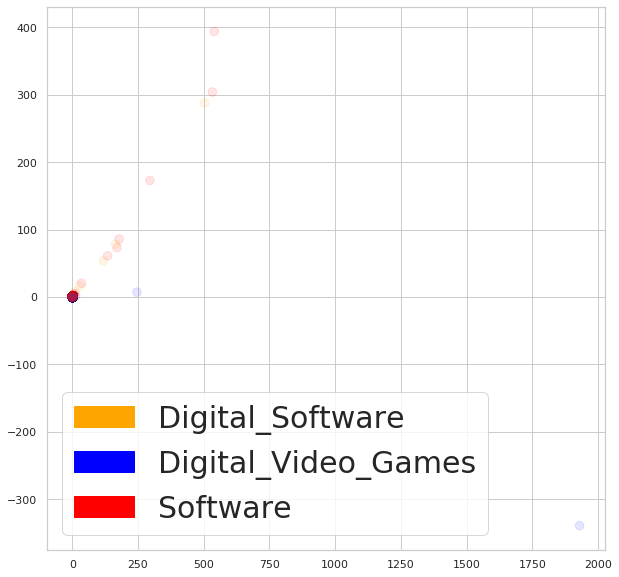

In [78]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. Let's see if we can still fit a useful model on them.

### **Fitting a classifier**
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

### **Logistic regression**

In [79]:
# balance classes 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
classes = np.unique(y_train)
class_weights = dict(zip(classes, class_weights))
class_weights

{0: 1.9222758487320966, 1: 1.3712913716788184, 2: 0.5712510989407373}

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=30.0, class_weight=class_weights, #class_weight = 'balanced', 
                         solver='newton-cg', 
                         multi_class='multinomial', n_jobs=1, random_state=40) #, n_jobs=-1 (default) all, -2 all cpus but one are used
clf.fit(X_train_counts, y_train) #, class_weight=class_weights to balance data

In [ ]:
y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
plt.hist(y_predicted_counts) 

### Evaluation
Let's start by looking at some metrics to see if our classifier performed well at all.

In [ ]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

### **Inspection**
A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(15, 15))
plot = plot_confusion_matrix(cm, classes=['Digital_Software', 'Digital_Video_Games', 'Software'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

In [ ]:
#IMPORTANCE OF WORDS
importance = get_most_important_features(count_vectorizer, clf, 10)

In [ ]:
importance[1]['tops'] #tops for video games

In [ ]:
importance[0]['tops'] #digital software

In [ ]:
importance[2]['tops'] #software

In [ ]:
#video games (1)
top_scores_video = [a[0] for a in importance[1]['tops']]
top_words_video = [a[1] for a in importance[1]['tops']]
#digital software (0)
top_scores_digital = [a[0] for a in importance[0]['tops']]
top_words_digital = [a[1] for a in importance[0]['tops']]
##software
top_scores_software = [a[0] for a in importance[2]['tops']]
top_words_software = [a[1] for a in importance[2]['tops']]

print("Most important words")
plot_important_words(top_scores_video, top_words_video, name = 'Digital video Games')
plot_important_words(top_scores_digital, top_words_digital, name = 'Digital Software')
plot_important_words(top_scores_software, top_words_software, name = 'Software')

## **TFIDF Bag of Words**

Let's try a slightly more subtle approach. Now, we will use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent (as of, the and others), because they just add noise.

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train['product_title'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['product_title'])

In [ ]:
print(X_train_tfidf.shape)

In [ ]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight= class_weights,# 'balanced', 
                               solver='newton-cg', 
                         multi_class='multinomial', n_jobs=1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf))

In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Digital_Software', 'Digital_Video_Games', 'Software'], normalize=True, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### Looking at important coefficients of the model


In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

In [ ]:
#video games (1)
top_scores_video = [a[0] for a in importance_tfidf[1]['tops']]
top_words_video = [a[1] for a in importance_tfidf[1]['tops']]
#digital software (0)
top_scores_digital = [a[0] for a in importance_tfidf[0]['tops']]
top_words_digital = [a[1] for a in importance_tfidf[0]['tops']]
##software
top_scores_software = [a[0] for a in importance_tfidf[2]['tops']]
top_words_software = [a[1] for a in importance_tfidf[2]['tops']]

print("Most important words")
plot_important_words(top_scores_video, top_words_video, name = 'Digital video Games') 
plot_important_words(top_scores_digital, top_words_digital, name = 'Digital Software')
plot_important_words(top_scores_software, top_words_software, name = 'Software')

The words the model picked up look much more relevant! Although our metrics on our held out validation set haven't increased much, we have much more confidence in the terms our model is using.

## **word2vec**

### Capturing semantic meaning
Our first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. 

### Enter word2vec
Word2vec is a model that was pre-trained on a very large set of sentences, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for our classifier, is to average word2vec scores of all words in our sentence.

In [ ]:
#!pip install gensim
#!pip install --upgrade pip

#!wget https://github.com/mmihaltz/word2vec-GoogleNews-vectors/blob/master/GoogleNews-vectors-negative300.bin.gz

**Note:** The load_word2vec_format() method also has an optional limit argument which will only load the supplied number of vectors – so you could use limit=500000 to cut the memory requirements by about 5/6ths. (And, since the GoogleNews and other vector sets are usually ordered from most- to least-frequent words, you'll get the 500K most-frequent words. Lower-frequency words generally have much less value and even not-as-good vectors, so it may not hurt much to ignore them.)

In [ ]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit = 100000)  

# data to introduce in the model.

In [ ]:
df.head(2)

In [ ]:
list_labels = df["product_category"].tolist()
df_corpus2 = df[["product_category", 'product_title', 'token_product_title']] # introduce more columns

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, df_corpus2, name = 'token_product_title')
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

In [ ]:
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

These look a little bit more separated, let's see how our logistic regression does on them!

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight = class_weights, #class_weight='balanced', 
                             solver = 'newton-cg', 
                         multi_class = 'multinomial', random_state = 40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Digital_Software', 'Digital_Video_Games', 'Software'], normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [ ]:
# **More values for the logistic**

In [ ]:
dicti_n = {0:"Digital_Software", 1:"Digital_Video_Games", 2:"Software"}

In [ ]:
#clf_w2v.score(X, y)
arr = clf_w2v.predict_proba(X_test_word2vec)
df_predict= pd.DataFrame(data=arr)
df_predict.columns = ["Digital_Software", "Digital_Video_Games", "Software"]
arr = clf_w2v.predict(X_test_word2vec)
df_predict['predicted_label'] = pd.DataFrame(data=arr.flatten())
df_predict['prediction_title'] = df_predict['predicted_label'].copy()
df_predict = df_predict.replace({"prediction_title": dicti_n})
arr = np.array(y_test_word2vec)
df_predict['real_label'] = pd.DataFrame(data=arr.flatten())
df_predict["max_pred"] = df_predict[['Digital_Software', 'Digital_Video_Games','Software']].max(axis=1)
print(df_predict.shape)
df_predict.head()

In [ ]:
df_predict[df_predict['max_pred'] <.60].tail(20)

In [ ]:
df_predict_long = pd.melt(df_predict, id_vars=['predicted_label', 'prediction_title'])
df_predict_long.head()

In [ ]:
import seaborn as sns
sns.kdeplot(df_predict_long.loc[(df_predict_long['variable']=='Software'), 
            'value'], color='r', shade=True, Label='Software') 
sns.kdeplot(df_predict_long.loc[(df_predict_long['variable']=='Digital_Software'), 
            'value'], color='b', shade=True, Label='Digital_Software')   
sns.kdeplot(df_predict_long.loc[(df_predict_long['variable']=='Digital_Video_Games'), 
            'value'], color='b', shade=True, Label='Digital_Video_Games')  

### Further inspection
In order to provide some explainability, we can leverage a black box explainer such as LIME.

In [ ]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

df_corpus = df['product_title'] #df['review_headline']#df['full_text']
#df_corpus = df['review_body', 'review_headline']
df_labels = df["product_category"] 


X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(df_corpus, df_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [ ]:
def explain_one_instance(instance, class_names):
    '''
    num_features: num of features to use to explain
    top_labels: number of labels to use
    '''
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=15,  top_labels=2)
    return exp

def visualize_one_exp(features, labels, index, class_names):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [ ]:
X_test_data

In [ ]:
class_names = ['Digital_Software', 'Digital_Video_Games', 'Software']
visualize_one_exp(X_test_data, y_test_data, 54, class_names)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 160, class_names)

In [ ]:
visualize_one_exp(X_test_data, y_test_data, 31937, class_names)

In [ ]:
label_to_text = {
    0: "Digital_Software", 
    1: "Digital_Video_Games", 
    2: "Software"
}
random.seed(40)
#importance of words
sorted_contributions = get_statistical_explanation(X_test_data.tolist(), 100, word2vec_pipeline, label_to_text)

In [ ]:
sorted_contributions

In [ ]:
#Software
top_words_Software = sorted_contributions['Software']['tops'][:10].index.tolist()
top_scores_Software = sorted_contributions['Software']['tops'][:10].tolist()
top_words_GAMES = sorted_contributions['Digital_Video_Games']['tops'][:10].index.tolist()
top_scores_GAMES = sorted_contributions['Digital_Video_Games']['tops'][:10].tolist()
top_words_Digital = sorted_contributions['Digital_Software']['tops'][:10].index.tolist()
top_scores_Digital = sorted_contributions['Digital_Software']['tops'][:10].tolist()

plot_important_words(top_scores_Software, top_words_Software, "Software")
plot_important_words(top_scores_GAMES, top_words_GAMES, "Digital Video Games")
plot_important_words(top_scores_Digital, top_words_Digital, 'Digital Software')
 

## **Conclusion:**

We get better results with **TFIDF Bag of Words** option. Also, aggregate review info to the model does not help to the improvement of the results of the model that only consider 'product title'. Further analysis are required to get a better model.

# **NEXT STEPS**

### Based in the results there are several things to do to improve the results:
1. Improve the text treatment, there are words that have misspelling or not sense. More time cleaning it is necessary. Also, it is necessary to spend more time cleaning reviews (eliminate adjectives, verbs, keep only noums that can help to identify the category).
2. Use n_grams > 1. A word by itself may mean nothing, specially when we are treating with names of products.
3. This first approach was mostly exploratory, for this reason we only use logistic regression, but there are models that may help to improve the results (based tree methodologies, deep leaning, bayesian methods, between others), aditionally would be interesting combine different methodolofies using emsemble methodologies like (max voting, averaging, bagging or boosting). Compare the results with ROC curves and information criteria as AIC and BIC.
4. We can try to improve the results combining text with numerical variables. Use number of votes to give more weights to those reviews with more votes may help to find better keywords for the products. Include a label for relevant/irrelenvant information based in the available information.
5. Use Spark to speed the results.
6. Use methodologies as SMOTE to balance the data.
7. Explore other alternative to Word2Vect like: fastText GloVe or ELMO. Consider other alternatives like pre-trained NLP models to get better results, as for example BERT, ULMFIT, between others.
8. Use BlazingText’s implemetation of Word2Vec.
9. Use H2OAutoML algorithm to if we can improve the results.
10. INclude more categories to the analysis.
11. Implement the ideas wrote at the beggining to fight misclassification issues.
12. During the treatment we eliminate numbers, because we think this may aggregate noise to result. We may recheck this treatment and evaluate which may remain in the trining dataset.